In [426]:
import numpy as np
from numba import jit

from py.model import *
from py.scores import *

import pandas as pd
# from SpringRank import SpringRank

from matplotlib import pyplot as plt

from scipy.optimize import root, minimize
from scipy.optimize.slsqp import approx_jacobian
from itertools import product

from autograd import jacobian


import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Arial Unicode MS"

In [485]:
cset = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377']
cset_muted = ['#CC6677', '#332288', '#DDCC77', '#117733', '#88CCEE', '#882255', '#44AA99', '#999933', '#AA4499', '#DDDDDD','#000000']

In [417]:
def compute_gamma(s, beta):
    gamma = np.exp(beta*s)
    gamma = gamma/gamma.sum()
    return(gamma)

def make_s(s_1, s_2, n_1, n):
        
    s_1 = s_1
    s_2 = s_2
    
    n_1 = int(n_1)
    n_2 = n - n_1
    
    s = np.zeros(n)
    s[0:n_1] += 1*s_1
    s[n_1:n] += 1*s_2
#     s = s - (s.sum()-1)/n 
    return(s)

def make_gamma(s_1, s_2, n_1, n, beta):
    s = make_s(s_1, s_2, n_1, n)

    return(compute_gamma(np.sqrt(s), beta)) # for root-degree score

def f(s_1, s_2, n_1, n, beta):
    return(make_s(s_1, s_2, n_1, n) - make_gamma(s_1, s_2, n_1, n, beta))

So, we'd like to organize this calculation in a nicer fashion. One way to do this will be to build up a data frame, sort on certain features, and then group them appropriately. We'll need iterators for n_1 and beta. We'll also need to allow for multiple solutions...

# Compute the space of solutions

In [494]:
BETA_GRID = np.linspace(0, 10, 201)
n_1   = np.arange(1, 6)
rep = np.arange(0, 101)

n = 10

def g(row):
    x0 = np.random.rand(2)
    x0 = x0 / x0.sum()
    res = root(lambda s: f(s[0],s[1], row.n_1, n, row.beta)[[0,n-1],], x0 = x0, tol = 10**(-8))
    if res['success']:
        return(pd.Series(res['x'], index = ['s_1', 's_2']))
    else:
        return(pd.Series([np.nan, np.nan], index = ['s_1', 's_2']))

In [495]:
df = pd.DataFrame(list(product(BETA_GRID, n_1, rep)), columns=['beta', 'n_1', 'rep'])

df = pd.concat([df, df.apply(g, axis = 1, result_type='expand')], axis = 1) # compute a bunch of equilibria
df = df.sort_values(['beta', 'n_1', 's_1'])
df = df[df.s_1.notnull()]
df['s_1'] = np.round(df.s_1, 3)
df['s_2'] = np.round(df.s_2, 3)
df['s1'] = df[['s_1', 's_2']].max(axis = 1)
df['s2'] = df[['s_1', 's_2']].min(axis = 1)
df = df.drop_duplicates(['n_1', 'beta', 's1', 's2'])
df = df.drop(['s_1', 's_2', 'rep'], axis = 1)

df['group'] = df.groupby(['beta', 'n_1'])['s1'].rank(method = 'first')

df = pd.concat([df, df.apply(lambda row: pd.Series(make_s(row.s1, row.s2, row.n_1, n)[[0,-1]], index = ['G1', 'G2'],),
                            result_type = 'expand',
                            axis = 1)],
              axis = 1)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in sqrt


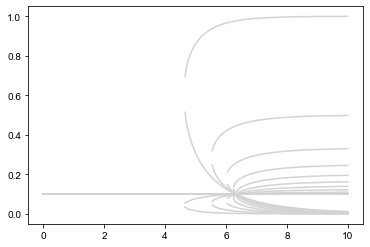

In [497]:
p = df.groupby(['n_1','group' ]).apply(lambda g: plt.plot(g.beta, g.G1, color = 'lightgrey', zorder = 1))
p = df.groupby(['n_1','group' ]).apply(lambda g: plt.plot(g.beta, g.G2, color = 'lightgrey', zorder = 1))
# plt.semilogy()

# Compute stability

In [673]:
def jacobian(n_1, s_1, s_2, n, beta):
    s = make_s(s_1, s_2, n_1, n)
    gamma = compute_gamma(s, beta)
    Gamma = np.diag(gamma)
    J = beta/2*(Gamma - np.outer(gamma, gamma)).dot(np.diag(s**(-1/2)))
    return(J)

def test_stable(n_1, s_1, s_2, n, beta):
    J = jacobian(n_1, s_1, s_2, n, beta)
    try:
        stable = np.abs(np.linalg.eig(J)[0]).max() < .98 # bit of a fudge factor
        return(stable)
    except np.linalg.LinAlgError:
        return(False)

In [674]:
df['stable'] = df.apply(lambda row: test_stable(row.n_1, row.s1, row.s2, n, row.beta), axis = 1)
# smoothing, needs some care
# df['stable'] = df.groupby(['n_1', 'group'])['stable'].transform(lambda g: g.max())

idx = df.groupby(['beta'])['s1'].transform(max) == df['s1']
# df.stable[idx] = True

# df['stable']

# df['stable'] = df.eig < 1

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in power
  """


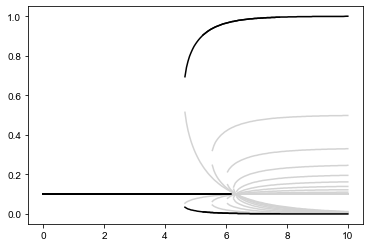

In [675]:
colors = ['lightgrey', 'black']
p = df.groupby(['n_1','group', 'stable']).apply(lambda g: plt.plot(g.beta, g.G1, zorder = 1, color = colors[int(g.stable.max())]))
p = df.groupby(['n_1','group', 'stable']).apply(lambda g: plt.plot(g.beta, g.G2, zorder = 1, color = colors[int(g.stable.max())]))

ix = df.G1 > .9

plt.plot(df.beta[ix], df.G1[ix], zorder = 1, color = 'black')
plt.plot(df.beta[ix], df.G2[ix], zorder = 1, color = 'black')

# Simulations

In [680]:
n = 10

def linear_feature(s):
    return(np.outer(np.ones(len(s)), s))

A0 = np.random.rand(n,n)
A0 = A0/A0.sum()

lam = .9995
n_rounds = 50000

m_updates = 1

b_grid = 51
BETAS = np.linspace(0,10, b_grid)

V = np.zeros((b_grid, n))

M = model()
M.set_score(score_function = lambda A: powered_degree_score(A, .5))
M.set_features([linear_feature])

for j in range(b_grid):

    M.simulate(beta = np.array([BETAS[j]]), 
                       lam = lam, 
                       A0 = A0, 
                       n_rounds = n_rounds, 
                       update = stochastic_update, 
                       m_updates = m_updates)
    GAMMA = M.get_rates()
    GAMMA = np.sort(GAMMA, axis = 2)
    V[j] = GAMMA[(-2000):(-1)].mean(axis = (0,1))

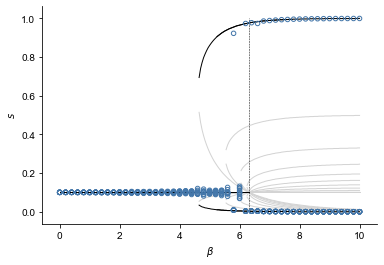

In [683]:
fig = plt.figure()
ax = fig.add_subplot(111)

pred = 2*n**(1/2)

colors = ['lightgrey', 'black']
p = df.groupby(['n_1','group', 'stable']).apply(lambda g: ax.plot(g.beta, g.G1, zorder = 1, color = colors[int(g.stable.max())], linewidth = 1))
p = df.groupby(['n_1','group', 'stable']).apply(lambda g: ax.plot(g.beta, g.G2, zorder = 1, color = colors[int(g.stable.max())], linewidth = 1))

# a bit of fudge in the plot due to numerical issues in computing the Jacobian
ix = df.G1 > .9

plt.plot(df.beta[ix], df.G1[ix], zorder = 1, color = 'black', linewidth = 1)
plt.plot(df.beta[ix], df.G2[ix], zorder = 1, color = 'black', linewidth = 1)

plt.plot([0, pred], [1/n, 1/n], zorder = 1, color = 'black', linewidth = 1)

# plt.ylim(10**(-3), 1.2)
v = ax.vlines(x = pred, 
                    ymin = 0, 
                    ymax = 1, 
                    linewidth = .5, 
                    linestyle = 'dashed')

for j in range(n):
    ax.scatter(BETAS, V[:,j],   s = 20, alpha = 1, zorder = 2 ,facecolors='none', edgecolors = cset[0])

    
ax.set(xlabel = r'$\beta$', 
       ylabel = r'$s$')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('fig/degree_sim_with_curves.png', dpi = 300, bbox_inches = 'tight')

In [682]:
np.savetxt('throughput/degree_score_trajectory.txt', V)